In [1]:
from copy import copy
from time import time

import matplotlib.pyplot as plt
import pandas as pd

from HARK.Calibration.Income.IncomeTools import (
    CGM_income,
    parse_income_spec,
    parse_time_params,
)
from HARK.ConsumptionSaving.ConsIndBequestModel import (
    TerminalBequestConsumerType,
    init_lifecycle,
)
from HARK.datasets.life_tables.us_ssa.SSATools import parse_ssa_life_table
from HARK.datasets.SCF.WealthIncomeDist.SCFDistTools import income_wealth_dists_from_scf
from HARK.utilities import plot_funcs

In [2]:
birth_age = 25
death_age = 90
adjust_infl_to = 1992
income_calib = CGM_income
education = "College"

# Income specification
income_params = parse_income_spec(
    age_min=birth_age,
    age_max=death_age,
    adjust_infl_to=adjust_infl_to,
    **income_calib[education],
    SabelhausSong=True,
)

# Initial distribution of wealth and permanent income
dist_params = income_wealth_dists_from_scf(
    base_year=adjust_infl_to, age=birth_age, education=education, wave=1995
)

# We need survival probabilities only up to death_age-1, because survival
# probability at death_age is 1.
liv_prb = parse_ssa_life_table(
    female=True, cross_sec=True, year=2004, min_age=birth_age, max_age=death_age - 1
)

# Parameters related to the number of periods implied by the calibration
time_params = parse_time_params(age_birth=birth_age, age_death=death_age)

# Update all the new parameters
params = copy(init_lifecycle)
params.update(time_params)
params.update(dist_params)
params.update(income_params)
params.update({"LivPrb": [1.0] * len(liv_prb)})

In [3]:
# Make and solve an idiosyncratic shocks consumer with a finite lifecycle
LifecycleExample = TerminalBequestConsumerType(**params)
# Make this consumer live a sequence of periods exactly once
LifecycleExample.cycles = 1

In [4]:
start_time = time()
LifecycleExample.solve()
end_time = time()
print(f"Solving a lifecycle consumer took {end_time - start_time} seconds.")
LifecycleExample.unpack("cFunc")

Solving a lifecycle consumer took 0.2072157859802246 seconds.


Consumption functions


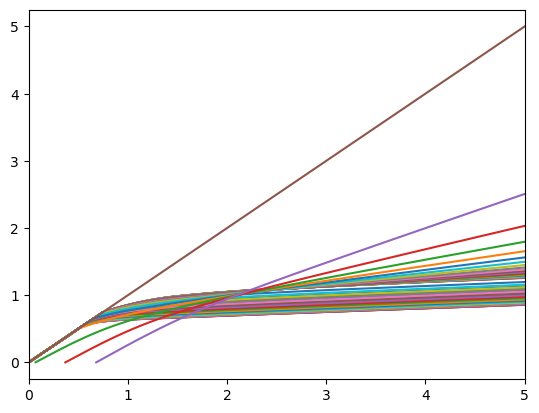

In [5]:
# Plot the consumption functions
print("Consumption functions")
plot_funcs(LifecycleExample.cFunc, 0, 5)

In [6]:
# Number of LifecycleExamples and periods in the simulation.
LifecycleExample.AgentCount = 500
LifecycleExample.T_sim = 200

# Set up the variables we want to keep track of.
LifecycleExample.track_vars = ["aNrm", "cNrm", "pLvl", "t_age", "mNrm"]

# Run the simulations
LifecycleExample.initialize_sim()
LifecycleExample.simulate()

{'aNrm': array([[0.29141706, 0.97356639, 0.35994782, ..., 1.79220048, 2.87211978,
         0.2443327 ],
        [0.24130905, 0.97453556, 0.64324875, ..., 1.74377638, 1.85905111,
         0.14863463],
        [0.6153681 , 1.91634253, 0.63123388, ..., 1.43034257, 2.64640602,
         0.97648322],
        ...,
        [2.56695496, 0.23504655, 0.23702557, ..., 0.51827736, 5.05257139,
         0.44611177],
        [3.01218093, 0.22595191, 0.43258047, ..., 1.01515648, 5.01372597,
         0.38761098],
        [3.63406985, 0.39570002, 0.75994966, ..., 2.20562359, 3.25351243,
         0.46101812]]),
 'cNrm': array([[0.83140282, 0.93329433, 0.84997578, ..., 0.99616691, 1.06769915,
         0.81599416],
        [0.80494577, 0.91713678, 0.88415928, ..., 0.973894  , 0.9816509 ,
         0.76671469],
        [0.87118726, 0.9710918 , 0.87312311, ..., 0.93908538, 1.01675376,
         0.90580828],
        ...,
        [1.01188468, 0.79691066, 0.79761224, ..., 0.85857293, 1.15810773,
         0.8474688

In [7]:
raw_data = {
    "Age": LifecycleExample.history["t_age"].flatten() + birth_age - 1,
    "pIncome": LifecycleExample.history["pLvl"].flatten(),
    "nrmM": LifecycleExample.history["mNrm"].flatten(),
    "nrmC": LifecycleExample.history["cNrm"].flatten(),
}

Data = pd.DataFrame(raw_data)
Data["Cons"] = Data.nrmC * Data.pIncome
Data["M"] = Data.nrmM * Data.pIncome

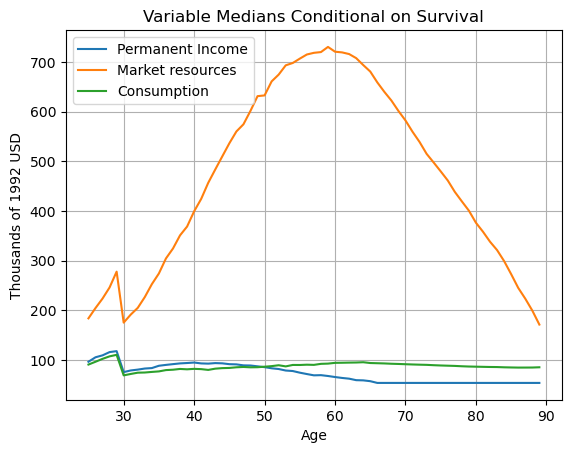

In [8]:
# Find the mean of each variable at every age
AgeMeans = Data.groupby(["Age"]).median().reset_index()

plt.figure()
plt.plot(AgeMeans.Age, AgeMeans.pIncome, label="Permanent Income")
plt.plot(AgeMeans.Age, AgeMeans.M, label="Market resources")
plt.plot(AgeMeans.Age, AgeMeans.Cons, label="Consumption")
plt.legend()
plt.xlabel("Age")
plt.ylabel("Thousands of {} USD".format(adjust_infl_to))
plt.title("Variable Medians Conditional on Survival")
plt.grid()